In [1]:
import numpy as np
import math
import PIL
from matplotlib.pyplot import imshow

In [27]:
img = PIL.Image.open('lena.png', 'r')
key_img = PIL.Image.open('key1.2.jpg', 'r')

In [28]:
type(img)

PIL.PngImagePlugin.PngImageFile

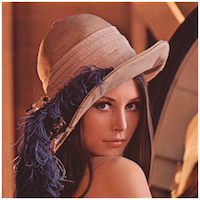

In [29]:
img

In [30]:
import cv2
img1 = cv2.imread('lena.png',0) 

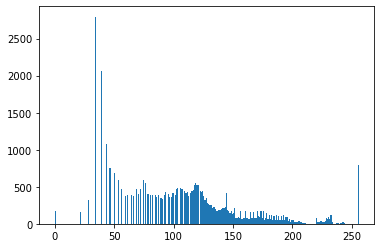

In [31]:
from matplotlib import pyplot as plt
plt.hist(img1.ravel(),256,[0,256]) 
plt.show() 

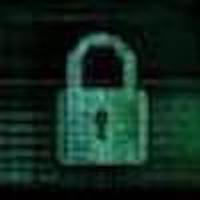

In [32]:
key_img

In [33]:
img_arr = np.asarray(img)

In [34]:
img_arr.shape

(200, 200, 3)

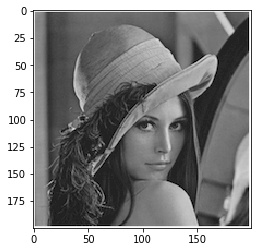

In [35]:
imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

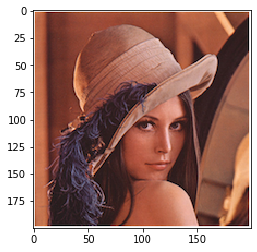

In [36]:
imshow(img_arr)

In [37]:
key_img_arr = np.asarray(key_img)

In [38]:
key_img_arr.shape

(200, 200, 3)

In [39]:
img.getpixel((0, 0))

(255, 255, 255)

In [40]:
pix_val = list(img.getdata())

In [41]:
len(pix_val)

40000

In [42]:
pix_val_key = list(key_img.getdata())

In [43]:
len(pix_val_key)

40000

In [44]:
def make_gcd_matrix(key_img):
    
    pix_val_key = list(key_img.getdata())
    
    rows = key_img.size[0]
    cols = key_img.size[1]
    
    gcd_matrix = []

    temp_li = []
    for pix_val in pix_val_key:
        gcd1 = math.gcd(pix_val[0], pix_val[1])
        gcd2 = math.gcd(pix_val[1], pix_val[2])
        gcd3 = math.gcd(pix_val[2], pix_val[0])
        gcd = (gcd1, gcd2, gcd3)
        temp_li.append(gcd)
        if len(temp_li) % key_img.size[0] == 0:
            if len(temp_li) == 0:
                temp_li = []
            else:
                gcd_matrix.append(temp_li)
                temp_li = []
          
    return gcd_matrix

def get_sum_mod(gcd_matrix):
    sum_mod = []
    for i in range(len(gcd_matrix)):
        temp_sum_mod1 = 0
        temp_sum_mod2 = 0
        temp_sum_mod3 = 0
        for j in range(len(gcd_matrix[i])):
            if i == j:
                continue
            temp_sum_mod1 += gcd_matrix[i][j][0]
            temp_sum_mod2 += gcd_matrix[i][j][1]
            temp_sum_mod3 += gcd_matrix[i][j][2]
            
        temp_sum_mod = [temp_sum_mod1 % 256, temp_sum_mod2 % 256, temp_sum_mod3 % 256]
        
        sum_mod.append(temp_sum_mod)
    return sum_mod

def make_matrix_table(sum_mod):
    
    dict_matrix_table = {}
    dict_matrix_table[0] = {}
    dict_matrix_table[1] = {}
    dict_matrix_table[2] = {}
    for i in range(3):
        for j in range(256):
            dict_matrix_table[i][j] = []
    
    temp_list = [[i,i,i] for i in range(256)]
    
    for i in range(256):
        for k in range(len(temp_list)):
            for j in range(3):
                temp_list[k][j] += sum_mod[i % len(sum_mod)][j]
                temp_list[k][j] = temp_list[k][j] % len(temp_list)
                
        for j in temp_list:
            for l in range(3):
                dict_matrix_table[l][i].append(j[l])
#         l = 0
#         for j in temp_list:
#             dict_matrix_table[i][l] = j
#             l += 1
            
    return dict_matrix_table

In [45]:
gcd_matrix = make_gcd_matrix(key_img)
sum_mod = get_sum_mod(gcd_matrix)
dict_matrix_table = make_matrix_table(sum_mod)

In [46]:
def pad_image(img, key):
    
    img_dim = img.size
    key_dim = key.size
    img_arr = np.asarray(img)
    pad_size_width = img_dim[0] % key_dim[0]
    pad_size_height = img_dim[1] % key_dim[1]
    
    if pad_size_width != 0 or pad_size_height != 0:
        arr_width = np.zeros((img_dim[1], key_dim[0]-pad_size_width, 3), dtype = 'uint8')
        arr_height = np.zeros((key_dim[1] - pad_size_height, (img_dim[0] + key_dim[0] - pad_size_width), 3), dtype = 'uint8')
        padded_img = np.concatenate((img_arr, arr_width), axis = 1)
        padded_img = np.concatenate((padded_img, arr_height), axis = 0)      
        return padded_img
    else:
        return np.asarray(img)
    

In [47]:
padded_img = pad_image(img, key_img)

In [48]:
padded_img.shape

(200, 200, 3)

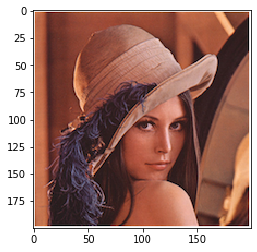

In [49]:
imshow(padded_img)

In [50]:
len(sum_mod)

200

In [51]:
padded_img[48%key_img.size[0],47%key_img.size[1]]

array([115,  56,  44], dtype=uint8)

In [52]:
padded_img[0,0,0]

255

In [65]:
def encrypt_img(padded_img, key):

    key_dim = key.shape
    cipher_img = np.empty(padded_img.shape, dtype = 'uint8')
    
    for i in range(padded_img.shape[0]):
        for j in range(padded_img.shape[1]):
            dict_key = key[i%key_dim[0],j%key_dim[1]]
#             print(dict_key)
#             print([padded_img[i,j,0]])
            for k in range(3):
                cipher_img[i][j][k] = dict_matrix_table[k][dict_key[k]][padded_img[i,j,k]]
                
    return cipher_img

In [66]:
cipher_img = encrypt_img(padded_img, key_img_arr)

In [67]:
cipher_img[0,0,0]

231

In [68]:
cipher_img.shape

(200, 200, 3)

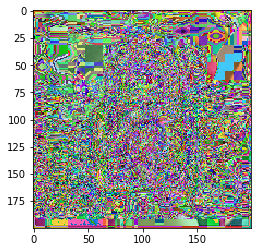

In [69]:
imshow(cipher_img)

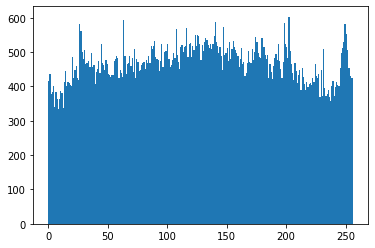

In [70]:
plt.hist(cipher_img.ravel(),256,[0,256]) 
plt.show() 

In [73]:
def decrypt_subs(cipher_img, key_img):
    
#     gcd_matrix = make_gcd_matrix(key_img)
#     sum_mod = get_sum_mod(gcd_matrix)
#     dict_matrix_table = make_matrix_table(sum_mod)

    key_dim = key_img.shape
    plain_img = np.empty(cipher_img.shape, dtype = 'uint8')
    
    for i in range(cipher_img.shape[0]):
        for j in range(cipher_img.shape[1]):
            dict_key = key_img[i%key_dim[0],j%key_dim[1]]
            for k in range(3):
#                 print(i)
#                 print(dict_matrix_table[k][dict_key[k]])
                ind = dict_matrix_table[k][dict_key[k]].index(cipher_img[i,j,k])
#                 for l in range(len(dict_matrix_table[k][dict_key[k]])):
#                     if dict_matrix_table[k][dict_key[k]][l] == cipher_img[i,j,k]:
#                         plain_img[i,j,k] = l
#                 plain_img[i,j,k] = dict_matrix_table1[k][ind]
                plain_img[i,j,k] = ind
#                         break
        print(i)
                        
    return plain_img

In [74]:
plain_img = decrypt_subs(cipher_img, key_img_arr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


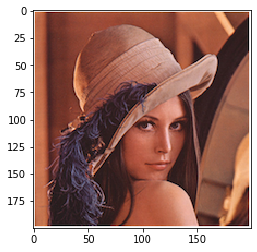

In [75]:
imshow(plain_img)

In [76]:
def trans(sum_mod):
    
    trans_mod = []
    for i in range(len(sum_mod)):
        temp = []
        for j in range(len(sum_mod[i])):
            temp.append(sum_mod[i][j] % len(sum_mod))
        trans_mod.append(temp)
        
    dim1 = []
    dim2 = []
    dim3 = []
    
    for i in range(len(trans_mod)):
        if trans_mod[i][0] not in dim1:
            dim1.append(trans_mod[i][0])
        
        if trans_mod[i][0] in dim1:
            for j in range(trans_mod[i][0]+1, len(trans_mod)):
                if j not in dim1:
                    dim1.append(j)
                    break
                if j == len(trans_mod) -1:
                    for k in range(0, trans_mod[i][0]):
                        if k not in dim1:
                            dim1.append(k)
                            break
                            
        if trans_mod[i][1] not in dim2:
            dim2.append(trans_mod[i][1])
            
        if trans_mod[i][1] in dim1:
            for j in range(trans_mod[i][1]+1, len(trans_mod)):
                if j not in dim2:
                    dim2.append(j)
                    break
                if j == len(trans_mod) -1:
                    for k in range(0, trans_mod[i][1]):
                        if k not in dim2:
                            dim2.append(k)
                            break

        if trans_mod[i][2] not in dim3:
            dim3.append(trans_mod[i][2])
            
        if trans_mod[i][2] in dim3:
            for j in range(trans_mod[i][2]+1, len(trans_mod)):
                if j not in dim3:
                    dim3.append(j)
                    break
                if j == len(trans_mod) -1:
                    for k in range(0, trans_mod[i][2]):
                        if k not in dim3:
                            dim3.append(k)
                            break
                            
    return dim1, dim2, dim3

In [77]:
dim1, dim2, dim3 = trans(sum_mod)

In [78]:
def encrypt_trans(dim1, dim2, dim3, subs_cipher_img):
    
    cipher_img = np.empty(subs_cipher_img.shape, dtype = 'uint8')
    
    for i in range(subs_cipher_img.shape[0]):
        for j in range(len(dim1)):
            index = dim1[j] 
            k = 0
            while index + k * len(dim1) < cipher_img.shape[1]:
                cipher_img[i,j + k * len(dim1),0] = subs_cipher_img[i, index + len(dim1)*k, 0]
                k += 1
            
    for i in range(subs_cipher_img.shape[0]):
        for j in range(len(dim2)):
            index = dim2[j] 
            k = 0
            while index + k * len(dim2) < cipher_img.shape[1]:
                cipher_img[i,j + k * len(dim2),1] = subs_cipher_img[i, index + len(dim2)*k, 1]
                k += 1

    for i in range(subs_cipher_img.shape[0]):
        for j in range(len(dim3)):
            index = dim3[j] 
            k = 0
            while index + k * len(dim3) < cipher_img.shape[1]:
                cipher_img[i,j + k * len(dim3),2] = subs_cipher_img[i, index + len(dim3)*k, 2]
                k += 1
            
    return cipher_img

In [79]:
cipher_img = encrypt_trans(dim1, dim2, dim3, cipher_img)

In [80]:
cipher_img.shape

(200, 200, 3)

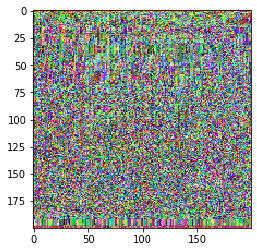

In [81]:
imshow(cipher_img)

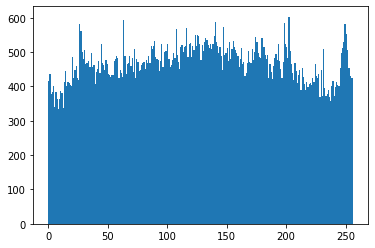

In [82]:
plt.hist(cipher_img.ravel(),256,[0,256]) 
plt.show() 

In [83]:
def encrypt_trans1(dim1, dim2, dim3, subs_cipher_img):
    
    cipher_img = np.empty(subs_cipher_img.shape, dtype = 'uint8')
    
    for j in range(subs_cipher_img.shape[1]):
        for i in range(len(dim1)):
            index = dim1[i] 
            k = 0
            while index + k * len(dim1) < cipher_img.shape[0]:
                cipher_img[i + k * len(dim1),j,0] = subs_cipher_img[index + len(dim1)*k, j, 0]
                k += 1
            
    for j in range(subs_cipher_img.shape[1]):
        for i in range(len(dim2)):
            index = dim2[i] 
            k = 0
            while index + k * len(dim2) < cipher_img.shape[0]:
                cipher_img[i+ k * len(dim2),j,1] = subs_cipher_img[index + len(dim2)*k, j, 1]
                k += 1

    for j in range(subs_cipher_img.shape[1]):
        for i in range(len(dim3)):
            index = dim3[i] 
            k = 0
            while index + k * len(dim3) < cipher_img.shape[0]:
                cipher_img[i+ k * len(dim3),j,2] = subs_cipher_img[index + len(dim3)*k, j, 2]
                k += 1
            
    return cipher_img

In [84]:
cipher_img = encrypt_trans1(dim1, dim2, dim3, cipher_img)
cipher_img.shape

(200, 200, 3)

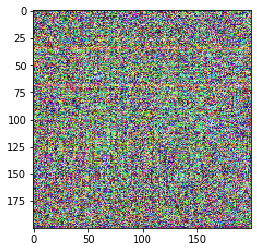

In [85]:
imshow(cipher_img)

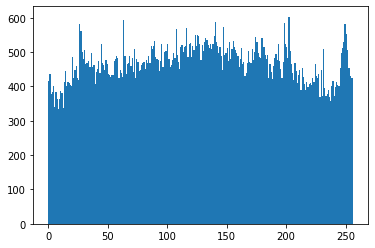

In [86]:
plt.hist(cipher_img.ravel(),256,[0,256]) 
plt.show() 

In [87]:
def decrypt_trans1(dim1, dim2, dim3, cipher_img):
        
    plain_img = np.empty(cipher_img.shape, dtype = 'uint8')
    
    for j in range(cipher_img.shape[1]):
        for i in range(len(dim1)):
#             current = cipher_img[i,j,0]
            index = dim1[i]
            k = 0
            while index + k * len(dim1) < cipher_img.shape[0]:
                plain_img[index + k * len(dim1),j, 0] = cipher_img[i + k * len(dim1),j,0]
                k += 1
        
    for j in range(cipher_img.shape[1]):
        for i in range(len(dim2)):
            index = dim2[i]
            k = 0
            while index + k * len(dim2) < cipher_img.shape[0]:
                plain_img[index + k * len(dim2),j, 1] = cipher_img[i + k * len(dim2),j,1]
                k += 1
                
    for j in range(cipher_img.shape[1]):
        for i in range(len(dim3)):
            index = dim3[i]
            k = 0
            while index + k * len(dim3) < cipher_img.shape[0]:
                plain_img[index + k * len(dim3),j, 2] = cipher_img[i + k * len(dim3),j,2]
                k += 1
            
    return plain_img

In [88]:
def decrypt_trans(dim1, dim2, dim3, cipher_img):
        
    plain_img = np.empty(cipher_img.shape, dtype = 'uint8')
    
    for i in range(cipher_img.shape[0]):
        for j in range(len(dim1)):
#             current = cipher_img[i,j,0]
            index = dim1[j]
            k = 0
            while index + k * len(dim1) < cipher_img.shape[1]:
                plain_img[i,index + k * len(dim1), 0] = cipher_img[i,j + k * len(dim1),0]
                k += 1
        
    for i in range(cipher_img.shape[0]):
        for j in range(len(dim2)):
            index = dim2[j]
            k = 0
            while index + k * len(dim2) < cipher_img.shape[1]:
                plain_img[i,index + k * len(dim2), 1] = cipher_img[i,j + k * len(dim2),1]
                k += 1
                
    for i in range(cipher_img.shape[0]):
        for j in range(len(dim3)):
            index = dim3[j]
            k = 0
            while index + k * len(dim3) < cipher_img.shape[1]:
                plain_img[i,index + k * len(dim3), 2] = cipher_img[i,j + k * len(dim3),2]
                k += 1
            
    return plain_img

In [89]:
plain_img = decrypt_trans1(dim1, dim2, dim3, cipher_img)
plain_img = decrypt_trans(dim1, dim2, dim3, plain_img)

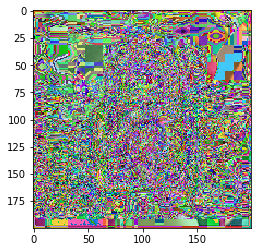

In [90]:
imshow(plain_img)

In [91]:
plain_img = decrypt_subs(plain_img, key_img_arr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


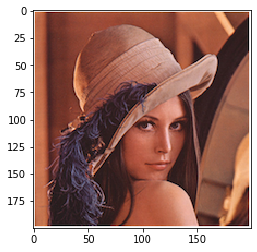

In [92]:
imshow(plain_img)

In [ ]:
dict_key = cipher_img[1%key_img.size[0],2%key_img.size[1]]
dict_matrix_table[dict_key[2]]

In [ ]:
#manipulating dict_matrix_table

dict_matrix_table1 = {}
dict_matrix_table1[0] = []
dict_matrix_table1[1] = []
dict_matrix_table1[2] = []

for i in dict_matrix_table:
    for j in dict_matrix_table[i]:
        for k in range(3):
#             print(k)
            dict_matrix_table1[k].append(dict_matrix_table[i][j][k])

In [ ]:
dict_matrix_table1

In [ ]:
dict_matrix_table

In [ ]:
dict_key[0]

In [ ]:
for l in range(len(dict_matrix_table[dict_key[0]])):
    if dict_matrix_table[dict_key[0]][l][0] == cipher_img[i,j,0]:
        print(l)

In [ ]:
def decrypt_subs(cipher_img, key_img):
    
    gcd_matrix = make_gcd_matrix(key_img)
    sum_mod = get_sum_mod(gcd_matrix)
    dict_matrix_table = make_matrix_table(sum_mod)

    key_dim = key_img.size
    plain_img = np.empty(padded_img.shape, dtype = 'uint8')
    
    for i in range(cipher_img.shape[0]):
        for j in range(cipher_img.shape[1]):
            dict_key = cipher_img[i%key_dim[0],j%key_dim[1]]
            for k in range(3):
                ind = dict_matrix_table1[k].index(dict_key[k])
#                 for l in range(len(dict_matrix_table[dict_key[k]])):
#                     if dict_matrix_table[dict_key[k]][l][k] == cipher_img[i,j,k]:
#                         plain_img[i,j,k] = l
#                 plain_img[i,j,k] = dict_matrix_table1[k][ind]
                plain_img[i,j,k] = ind
#                         break
        print(i)
                        
    return plain_img

In [ ]:
plain_img = decrypt_subs(plain_img, key_img)

In [ ]:
imshow(plain_img)

In [ ]:
plt.hist(plain_img.ravel(),256,[0,256]) 
plt.show() 